In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

In [2]:
pd.set_option("display.max_columns", None)    # 보여주는 열 값에 제한을 건다 -> 여기서는 None를 했기 때문에 제한이 없어진다

In [3]:
dataset = pd.read_excel("C:/Users/NT551/Desktop/06.17 깃/dataset_draft2.xlsx", index_col=0, dtype = {"gameId": "str"})   # 첫 번째 열(0번째 열)을 데이터프레임의 인덱스로 사용하도록 지정하는 옵션
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7194 entries, 0 to 7193
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gameId             7194 non-null   object 
 1   headtoHeadWinrate  7194 non-null   float64
 2   teamWinrateDiff    7194 non-null   float64
 3   Blue_Top_kda       7194 non-null   float64
 4   Blue_Jgl_kda       7194 non-null   float64
 5   Blue_Mid_kda       7194 non-null   float64
 6   Blue_Adc_kda       7194 non-null   float64
 7   Blue_Spt_kda       7194 non-null   float64
 8   Red_Top_kda        7194 non-null   float64
 9   Red_Jgl_kda        7194 non-null   float64
 10  Red_Mid_kda        7194 non-null   float64
 11  Red_Adc_kda        7194 non-null   float64
 12  Red_Spt_kda        7194 non-null   float64
 13  winner             7194 non-null   object 
dtypes: float64(12), object(2)
memory usage: 843.0+ KB


In [4]:
dataset["winner"].head()

0     Red
1     Red
2     Red
3     Red
4    Blue
Name: winner, dtype: object

In [5]:
label_incoder = LabelEncoder()   # 범주형 데이터(카테고리)를 수치형 데이터로 변환하는 데 사용
dataset["winner"] = label_incoder.fit_transform(dataset["winner"])
dataset["winner"].head()
# 밑의 결과값으로 보아 Red = 1  / Blue = 0


0    1
1    1
2    1
3    1
4    0
Name: winner, dtype: int32

In [6]:
dropped_dataset = dataset.drop(["gameId"], axis=1)
desired_X_column_list = list(dropped_dataset.columns)
desired_X_column_list.remove("winner")    # .remove("winner") 이 안에 들어가는 항목 제거
dropped_dataset.drop_duplicates(desired_X_column_list)  # 열 리스트(desired_X_column_list)를 기준으로 중복된 행을 제거하는 데 사용
y = dropped_dataset["winner"]
X = dropped_dataset.drop(["winner"], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7194 entries, 0 to 7193
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   headtoHeadWinrate  7194 non-null   float64
 1   teamWinrateDiff    7194 non-null   float64
 2   Blue_Top_kda       7194 non-null   float64
 3   Blue_Jgl_kda       7194 non-null   float64
 4   Blue_Mid_kda       7194 non-null   float64
 5   Blue_Adc_kda       7194 non-null   float64
 6   Blue_Spt_kda       7194 non-null   float64
 7   Red_Top_kda        7194 non-null   float64
 8   Red_Jgl_kda        7194 non-null   float64
 9   Red_Mid_kda        7194 non-null   float64
 10  Red_Adc_kda        7194 non-null   float64
 11  Red_Spt_kda        7194 non-null   float64
dtypes: float64(12)
memory usage: 730.6 KB


In [7]:
X.describe()

,headtoHeadWinrate,teamWinrateDiff,Blue_Top_kda,Blue_Jgl_kda,Blue_Mid_kda,Blue_Adc_kda,Blue_Spt_kda,Red_Top_kda,Red_Jgl_kda,Red_Mid_kda,Red_Adc_kda,Red_Spt_kda
count,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000,7194.000000
mean,0.495038,0.002245,4.449423,5.523583,5.805209,6.215429,5.571439,4.525407,5.585666,5.835033,6.270366,5.626504
std,0.184054,0.202201,1.766150,2.188871,2.250277,2.269533,2.325368,1.798515,2.207438,2.255128,2.310944,2.338421
min,0.083333,-0.677419,0.190476,0.569286,0.125000,0.511111,0.359524,0.166667,0.255952,0.166667,0.641667,0.111111
25%,0.333333,-0.130073,3.216667,3.968333,4.290000,4.650417,3.887143,3.280000,4.023750,4.276726,4.698750,3.980893
50%,0.500000,0.000000,4.413333,5.484813,5.705193,6.129330,5.434881,4.427688,5.484813,5.705193,6.129330,5.434881
75%,0.642857,0.131168,5.570000,6.912500,7.185000,7.652963,6.982500,5.609226,6.986250,7.240000,7.700000,7.019167
max,0.923077,0.696970,13.840000,14.450000,17.866667,17.466667,21.800000,14.733333,14.443333,17.333333,15.750000,16.250000


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# 80 / 20 으로 검증
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50)   # n_estimators -> 학습기 수
# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# use_label_encoder = False -> 경고주는 것을 False 함으로써 피한다
# 최신 XGBoost 버전에서 레이블 인코딩을 자동으로 처리하기 때문에 발생할 수 있는 경고 메시지를 피하기 위해 설정

Accuracy: 0.6157053509381515


In [17]:
#하이퍼파라미터 그리드 정의
# param_grid = {
#     'max_depth': [3, 4, 5, 6],           # 과적합 방지를 하기 위해 적당한 값이 필요
#     'learning_rate': [0.01, 0.1, 0.3],   # 기본 값 0.3 값이 낮아질수록 더 약한 학습기가 필요하다
#     'n_estimators': [100, 200, 300, 400],  # 학습기 수 
#     'colsample_bytree': [0.3, 0.7]        # 최대 트리 수 
# }



# set_params를 사용하여 매개변수 설정
# model.set_params(early_stopping_rounds=10)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100,200,300,400,500],
    'subsample': [0.6, 0.8, 1.0],           # 학습 데이터의 샘플링 비율 설정 / 1.0은 전체데이터를 다 사용하겠다는 의미
    'colsample_bytree': [0.6, 0.8, 1.0],    # 각 트리를 학습할 때 사용될 특성의 비율을 설정 / 낮은 값으로 설정하면 모델이 과적합되는 것을 방지
    'gamma': [0, 0.1, 0.3],            # 최소 손실 감소 값 제어 ( 값이 클수록 분기가 더 제한되며 더 보수적으로 학습 )
    'reg_lambda': [1, 5, 10],          # L2 규제 ( 가중치의 제곱합의 제약 ->강도 파라미터 -> 가중치를 작게 만들어 모델의 복잡도를 줄인다) -> 일반화 성능 향상
    'reg_alpha': [0, 1, 5]             # L1 규제 ( 절대값의 합을 제약 -> 모델이 중요한 특성만을 남기고 나머지를 제거하는 효과) -> 희소한 특성 다룰 때 유용
}

# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10) 

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                        #    estimator=model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,        # 중첩 수 (3-> 5 변경) -> 확인결과 (현재 데이터로는 3=5 값이 같게 나온다
                           verbose=2,   #  학습 과정 중간에 로깅 메시지가 출력됩니다. 이 메시지는 학습의 진행 상태, 각 트리의 손실 값, 학습률 등의 정보를 포함
                           n_jobs=1,     # 모든 CPU 코어 사용x / -1 모든 코어 사용o
                        #    early_stopping_rounds=10    # 조기 종료 설정
                           )   
# early_stopping_rounds=10 을 위의 코드에 적용 시키려고 했지만 grid_search에서는 지원하지 않는 옵션이다
# 이걸 적용시키기 위해서는 'fit' 메서드에서 사용해야한다
# Xgboost는 기본적으로 n_estimators가 100으로 설정되어 있다 만약에 위에서 따로 설정하지 않았다면 100으로 실행하여
# early_stopping=10 을 통해서 100개의 트리 + 10개의 트리를 더 설정하여 총 110개를 적용하여 생성한다

# 그리드 서치 수행
grid_search.fit(X_train, y_train,
                # early_stopping_rounds=10,      # 지정된 에폭 수 동안 개선되지 않으면 학습 중단
                eval_set=[(X_test, y_test)],   # eval_set : 검증 데이터 셋을 설정하여 학습 도중 평가를 수행
                verbose=True)
# fit 메서드에서 early_stopping_rounds 매개변수를 사용 x
# 이유 : scikit-learn 호환성을 위해 더 이상 사용되지 x
# -> 어떻게 해결해야하는가?
# 메서드에서 직접 전달하는 대신 생성자에서 설정하거나 set_params 메서드를 사용
# set_params 적용

# 최적의 하이퍼파라미터 출력
print(f"Best parameters found: {grid_search.best_params_}")

# 최적의 하이퍼파라미터로 모델 재학습
best_model = grid_search.best_estimator_

# 예측
y_pred_best = best_model.predict(X_test)

# 정확도 출력
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"mse with tuned parameters: {mse_best:.4f}")


Fitting 3 folds for each of 19440 candidates, totalling 58320 fits


KeyboardInterrupt: 

In [ ]:
feature_importances = best_model.feature_importances_
features = list(X.columns)
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df

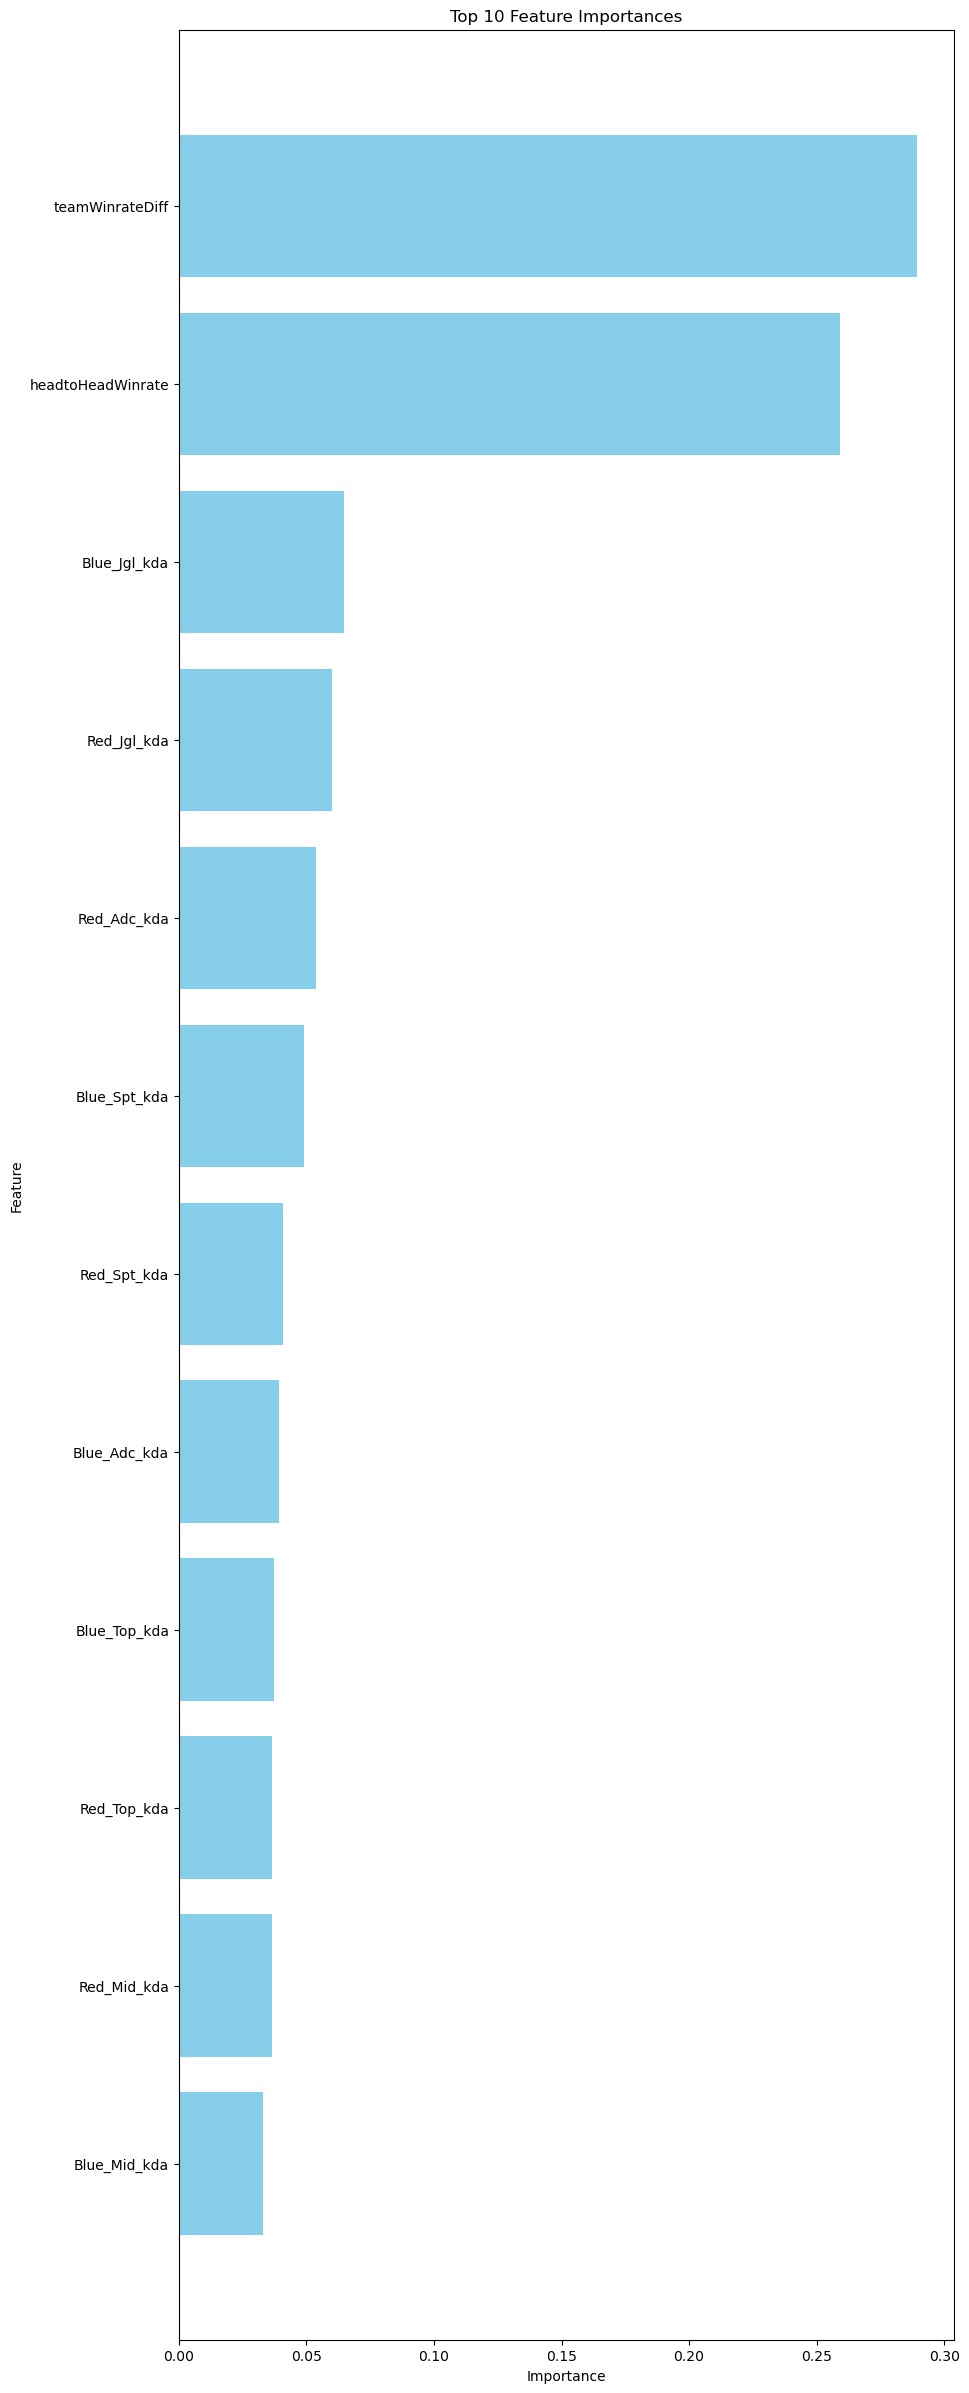

In [ ]:
plt.figure(figsize=(10, 30))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()   # plt.gca().invert_yaxis()는 Matplotlib 라이브러리에서 현재의 좌표 축을 반전시키는 명령어입니다. 이 명령어는 주로 그래프의 y축 방향을 뒤집어, 보통의 수평 축 방향과 반대로 설정하고자 할 때 사용
plt.show()